In [1]:
 import numpy as np
 # deep learning framework
 import tensorflow as tf
 # to obtain IMDB datasets
 import tensorflow_datasets as tfds
 # Keras API
 from tensorflow import keras
 # import required layers
 from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
 # to visualize the performance
 import matplotlib.pyplot as plt 

In [2]:
 data, meta = tfds.load('imdb_reviews/subwords8k',
                       with_info = True,
                       as_supervised = True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6397P1/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6397P1/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6397P1/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
data.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [4]:
 train = data['train']
 test = data['test']
 train, test

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [5]:
meta.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [6]:
 # extract the encoder
 encoder = meta.features['text'].encoder 

In [7]:
encoder.vocab_size

8185

In [8]:
print(encoder.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [9]:
 example = 'Analytics India Magazine !'
 enc = encoder.encode(example)
 enc 

[1291, 375, 8050, 1540, 8, 6552, 4, 2853, 7908, 442, 5219]

In [10]:
 for integer in enc:
     text = encoder.decode([integer])
     print('%4d : %s'%(integer, text)) 

1291 : An
 375 : al
8050 : y
1540 : tic
   8 : s 
6552 : Indi
   4 : a 
2853 : Mag
7908 : azi
 442 : ne
5219 :  !


#Preprocess the dataset

In [11]:
 BUFFER_SIZE = 10000
 BATCH_SIZE = 64
 AUTOTUNE = tf.data.AUTOTUNE
 train_data = train.shuffle(BUFFER_SIZE)
 train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))
 train_data = train_data.prefetch(AUTOTUNE)
 test_data = test.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))
 embed_layer = keras.layers.Embedding(encoder.vocab_size, 64) 

#Build the Model

In [12]:
 model = keras.Sequential([
     # embedding layer
     embed_layer,
     # bidirectional LSTM layers
     Bidirectional(LSTM(64, 
                        dropout=0.5, 
                        recurrent_dropout=0.5, 
                        return_sequences=True)),
     Bidirectional(LSTM(32, 
                        dropout=0.5, 
                        recurrent_dropout=0.5, 
                        return_sequences=True)),
     Bidirectional(LSTM(16, 
                        dropout=0.5, 
                        recurrent_dropout=0.5)),
     # Classification head
     Dense(64, activation='relu', kernel_regularizer='l2'),
     Dropout(0.5),
     Dense(1, activation='sigmoid')    
 ]) 


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                        

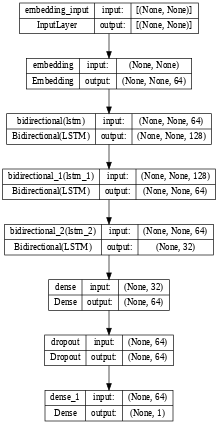

In [14]:
keras.utils.plot_model(model, show_shapes=True, dpi=48) #Model parameter

#Train the Model

In [15]:
 model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 

In [16]:
 history = model.fit(train_data, 
                     validation_data=test_data, 
                     epochs=2) 

Epoch 1/2
391/391 [==============================] - 4817s 12s/step - loss: 0.7634 - accuracy: 0.5544 - val_loss: 0.6969 - val_accuracy: 0.5001
Epoch 2/2
391/391 [==============================] - 4782s 12s/step - loss: 0.6739 - accuracy: 0.5977 - val_loss: 0.6811 - val_accuracy: 0.5633


# Model Performance Evaluation

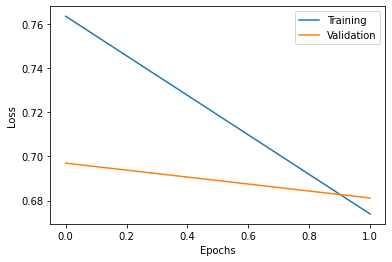

In [17]:
hist = history.history
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(labels=['Training', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

## Model Inference – Sentiment Analysis

In [18]:
# Sample prediction
samples = ['The plot is fantastic', 
          'The movie was cool and thrilling', 
          'one of the worst films I have ever seen']

# encode into integers
sample_encoded = [encoder.encode(sample) for sample in samples]

# pad with zeros to have same length 
sample_padded = []
for s in sample_encoded:
    pad_length = 128 - len(s)
    zeros = [0]*pad_length
    s.extend(zeros)
    s = tf.convert_to_tensor(s)
    sample_padded.append(s)
# convert into tensor before feeding the model
sample_padded = tf.convert_to_tensor(sample_padded)

#make predictions
predictions = model.predict(sample_padded)
predictions 

1/1 [==============================] - 1s 1s/step


array([[0.47989982],
       [0.47992393],
       [0.4802725 ]], dtype=float32)

### Sentiments analysis Results

In [19]:
 print('Predictions on sample test reviews... \n') #Prediction above 0.5 refers to a positive review and below 0.5 refers to a negative review.
 for i in range(len(samples)):
     pred = predictions[i][0]
     sentiment = 'positive' if pred>0.5 else 'negative'
     print('%40s : %s'%(samples[i], sentiment)) 

Predictions on sample test reviews... 

                   The plot is fantastic : negative
        The movie was cool and thrilling : negative
 one of the worst films I have ever seen : negative
